In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

RAW_DIR = "/kaggle/input/cats-data/cat_data/Cats"

print("IMG_SIZE:", IMG_SIZE)
print("BATCH_SIZE:", BATCH_SIZE)
print("RAW_DIR exists:", RAW_DIR)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Classes:", train_gen.class_indices)


In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(train_gen.num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


In [ ]:
model.save("cat_identity_mobilenetv2.keras")
print("Model saved successfully")

In [ ]:
plt.plot(history_1.history["accuracy"], label="Train P1")
plt.plot(history_1.history["val_accuracy"], label="Val P1")
plt.plot(history_2.history["accuracy"], label="Train P2")
plt.plot(history_2.history["val_accuracy"], label="Val P2")
plt.legend()
plt.title("Accuracy")
plt.show()


Class mapping: {0: 'Bibers', 1: 'Caramel', 2: 'Putchi', 3: 'Smokey'}


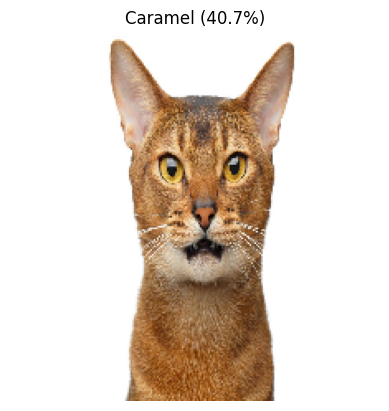

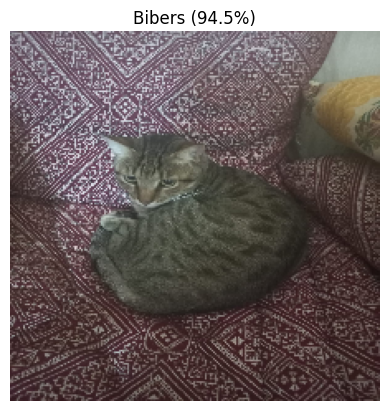

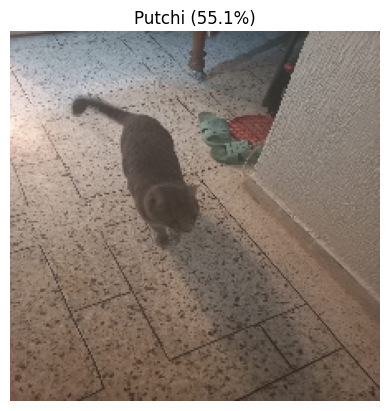

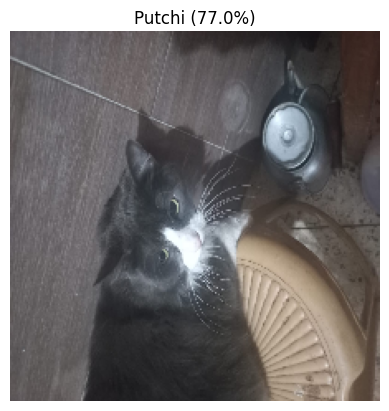

In [12]:
class_names = sorted([
    d for d in os.listdir(RAW_DIR)
    if os.path.isdir(os.path.join(RAW_DIR, d))
])
idx_to_class = {i: name for i, name in enumerate(class_names)}
print("Class mapping:", idx_to_class)

def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = tf.keras.utils.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    preds = model.predict(arr, verbose=0)[0]
    idx = np.argmax(preds)

    plt.imshow(img)
    plt.title(f"{idx_to_class[idx]} ({preds[idx]*100:.1f}%)")
    plt.axis("off")
    plt.show()


predict_image("/kaggle/input/test-cat/cat.jpg")
predict_image("/kaggle/input/test-cat3/cat3.jpeg")
predict_image("/kaggle/input/test-cat3/cat4.jpeg")

predict_image("/kaggle/input/test-cat3/cat6.jpeg")




